#**Data Preprocessing**

In [ ]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import os

def data_generator(path,img_size):
  data = []
  X_data = []
  Y_data = []
  labels = ["close","open"]
  for i in range(len(labels)):
    path_ = os.path.join(path,labels[i])
    for img in os.listdir(path_):
      try:
        image_ = image.load_img(os.path.join(path_,img),target_size=(150,150))
        image_array = image.img_to_array(image_)
        image_array = image_array/255.0
        data.append((image_array,i))
      except Exception as e:
        print(e)
  random.shuffle(data)
  for x,y in data:
    X_data.append(x)
    Y_data.append(y)
  return X_data,Y_data

test_path = "/content/drive/MyDrive/img_data/test"
X_test,Y_test = data_generator(test_path,150)

train_path = "/content/drive/MyDrive/img_data/train"
X_train,Y_train = data_generator(train_path,150)





In [ ]:
X_train = np.array(X_train).reshape(-1,150,150,3)
Y_train = np.array(Y_train).reshape(-1,1)

X_test = np.array(X_test).reshape(-1,150,150,3)
Y_test = np.array(Y_test).reshape(-1,1)

In [ ]:
import pickle

filename_1 = "dd_features_train.pkl"
pickle.dump(X_train,open(filename_1,"wb"))

filename_2 = "dd_labels_train.pkl"
pickle.dump(Y_train,open(filename_2,"wb"))

filename_3 = "dd_features_test.pkl"
pickle.dump(X_test,open(filename_3,"wb"))

filename_4 = "dd_labels_test.pkl"
pickle.dump(Y_test,open(filename_4,"wb"))

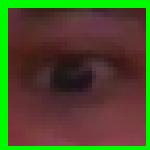

In [ ]:
image_ = image.load_img("/content/drive/MyDrive/img205.png",target_size=(150,150))
image_

#**Inception model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model


In [ ]:
inception_model = InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = (150,150,3)
)

for layers in inception_model.layers:
  layers.trainable = False

X = Flatten()(inception_model.output)
output = Dense(1)(X)
out = tf.keras.activations.sigmoid(output)

In [ ]:
model = Model(inputs = inception_model.input,outputs = output)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005,momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.0%
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.99):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

results = model.fit(
    X_train,
    Y_train,
    batch_size = 16,
    validation_data = (X_test,Y_test),
    validation_batch_size = 16,
    callbacks = [callbacks],
    epochs = 50
)

Epoch 1/50
209/209 [==============================] - 14s 68ms/step - loss: 0.0689 - accuracy: 0.9919 - val_loss: 0.0610 - val_accuracy: 0.9871
Epoch 2/50
209/209 [==============================] - 17s 80ms/step - loss: 0.0585 - accuracy: 0.9961 - val_loss: 0.0810 - val_accuracy: 0.9800
Epoch 3/50
209/209 [==============================] - 17s 79ms/step - loss: 0.1940 - accuracy: 0.9868 - val_loss: 0.0674 - val_accuracy: 0.9882
Epoch 4/50
209/209 [==============================] - 14s 67ms/step - loss: 0.0290 - accuracy: 0.9961 - val_loss: 0.0812 - val_accuracy: 0.9800
Epoch 5/50
209/209 [==============================] - 14s 67ms/step - loss: 0.0426 - accuracy: 0.9958 - val_loss: 0.0589 - val_accuracy: 0.9871
Epoch 6/50
209/209 [==============================] - 14s 67ms/step - loss: 0.0245 - accuracy: 0.9958 - val_loss: 0.0824 - val_accuracy: 0.9788
Epoch 7/50
209/209 [==============================] - 14s 67ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0593 - val_accuracy:

In [ ]:
model.save("dd-model1.h5")

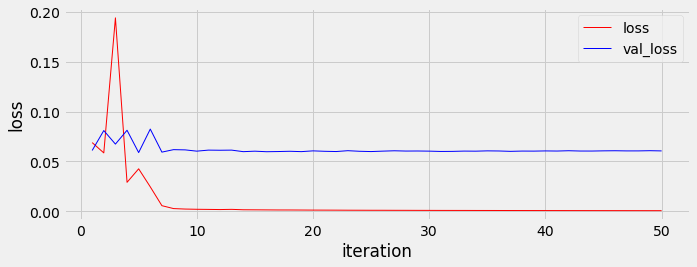

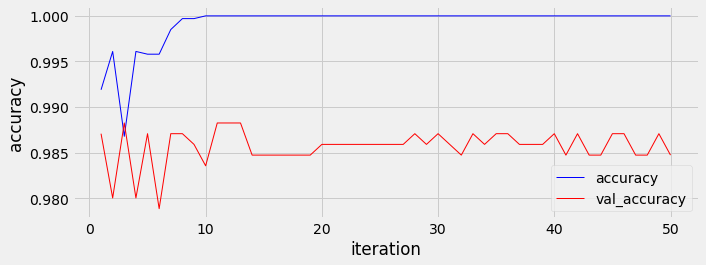

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

history_ = model.history.history


plt.style.use("fivethirtyeight")
color = ["red","blue","red"]


for i in range(2):
  plt.figure(figsize=(10,8))
  plt.subplot(2,1,i+1)
  plt.plot(range(1,51),list(history_.values())[i],label = list(history_.keys())[i],color = color[i],linewidth=1)
  plt.plot(range(1,51),list(history_.values())[i+2],label = list(history_.keys())[i+2],color = color[i+1],linewidth=1)
  plt.xlabel("iteration")
  plt.ylabel(list(history_.keys())[i])
  plt.legend()
  plt.show()
  print("\n")

In [ ]:
model = tf.keras.models.load_model("/content/dd-model1.h5")




accuracy 98.5


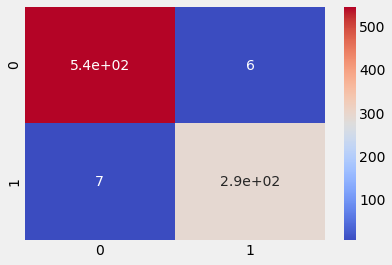

In [ ]:
#evaluating model
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.where(y>=0.5,1,0)

from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(Y_test,y_pred),annot=True,cmap="coolwarm")
print("\n\n")
print("accuracy %1.1f"%(accuracy_score(Y_test,y)*100))

#**VGG16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten

In [ ]:
vgg16_model = VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (150,150,3)
)

for layer in vgg16_model.layers:
  layer.trainable = False

X = Flatten()(vgg16_model.output)
output = Dense(1,activation='sigmoid')(X)

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
model = Model(inputs = vgg16_model.input,outputs = output)

In [ ]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
class callbacks_(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,log={}):
          if log.get("val_accuracy")>0.99:
            print("above 99% validation accuracy reached")
            self.model.stop_training = True

callbacks = callbacks_()

model.fit(
    X_train,
    Y_train,
    epochs = 50,
    validation_data = (X_test,Y_test),
    callbacks = [callbacks],
    validation_batch_size = 16,
    batch_size = 16
)

Epoch 1/50
209/209 [==============================] - 25s 105ms/step - loss: 0.4974 - accuracy: 0.7796 - val_loss: 0.6083 - val_accuracy: 0.6475
Epoch 2/50
209/209 [==============================] - 20s 95ms/step - loss: 0.3436 - accuracy: 0.8715 - val_loss: 0.4313 - val_accuracy: 0.9036
Epoch 3/50
209/209 [==============================] - 20s 95ms/step - loss: 0.2752 - accuracy: 0.9117 - val_loss: 0.3792 - val_accuracy: 0.8237
Epoch 4/50
209/209 [==============================] - 20s 96ms/step - loss: 0.2309 - accuracy: 0.9285 - val_loss: 0.3328 - val_accuracy: 0.8754
Epoch 5/50
209/209 [==============================] - 20s 96ms/step - loss: 0.2021 - accuracy: 0.9429 - val_loss: 0.3106 - val_accuracy: 0.8766
Epoch 6/50
209/209 [==============================] - 20s 96ms/step - loss: 0.1817 - accuracy: 0.9474 - val_loss: 0.2770 - val_accuracy: 0.9189
Epoch 7/50
209/209 [==============================] - 20s 96ms/step - loss: 0.1618 - accuracy: 0.9514 - val_loss: 0.2581 - val_accuracy

In [ ]:
model.save("dd-model2.h5")

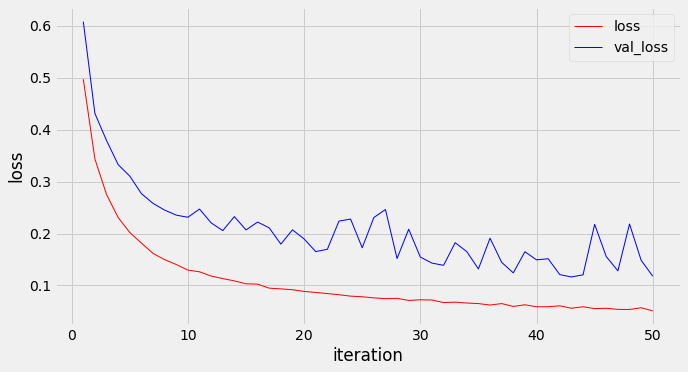

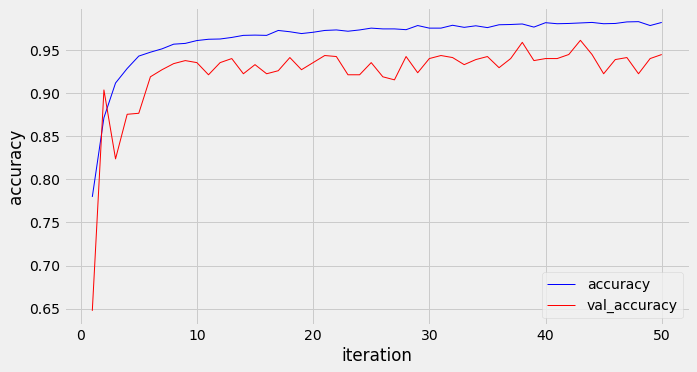

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

history_ = model.history.history


plt.style.use("fivethirtyeight")
color = ["red","blue","red"]


for i in range(2):
  plt.figure(figsize=(10,12))
  plt.subplot(2,1,i+1)
  plt.plot(range(1,51),list(history_.values())[i],label = list(history_.keys())[i],color = color[i],linewidth=1)
  plt.plot(range(1,51),list(history_.values())[i+2],label = list(history_.keys())[i+2],color = color[i+1],linewidth=1)
  plt.xlabel("iteration")
  plt.ylabel(list(history_.keys())[i])
  plt.legend()
  plt.show()
  print("\n")




accuracy 98.5


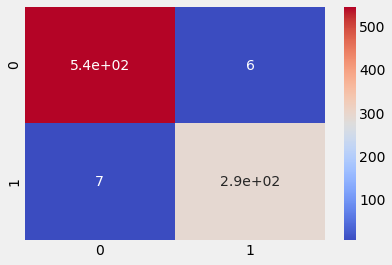

In [ ]:
#evaluating model
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.where(y>=0.5,1,0)

from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(Y_test,y_pred),annot=True,cmap="coolwarm")
print("\n\n")
print("accuracy %1.1f"%(accuracy_score(Y_test,y)*100))

#**SVM model**

In [ ]:
import pickle 
X_train = pickle.load(open("/content/drive/MyDrive/dd_data/dd_features_train.pkl","rb"))
Y_train = pickle.load(open("/content/drive/MyDrive/dd_data/dd_labels_train.pkl","rb"))
X_test = pickle.load(open("/content/drive/MyDrive/dd_data/dd_features_test.pkl","rb"))
Y_test = pickle.load(open("/content/drive/MyDrive/dd_data/dd_labels_test.pkl","rb"))

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


#here images should be fed in the form of 2d array and label as 1d array
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

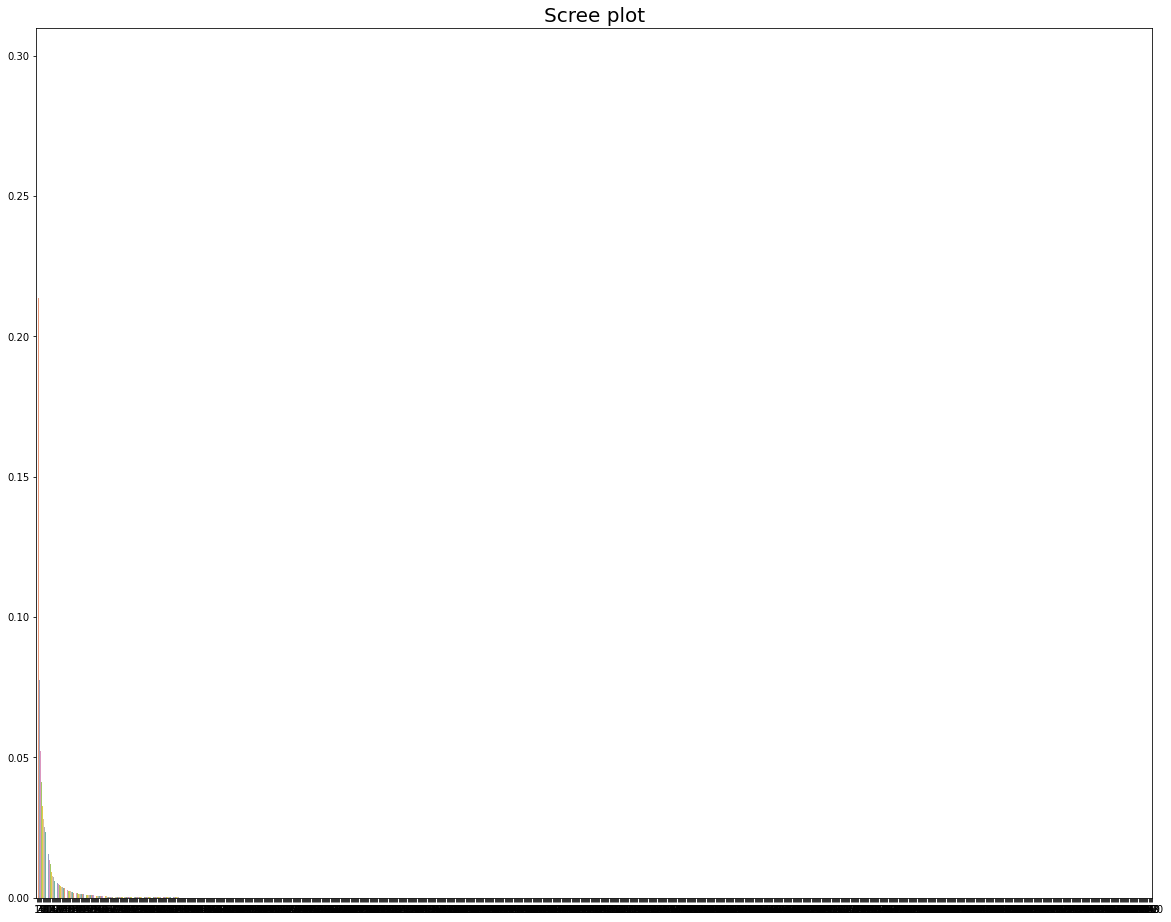

In [ ]:
# #dimensionality reduction
import seaborn as sns
import matplotlib.pyplot as plt

pca_ = PCA(1000).fit(X_train)
X_tr = pca_.transform(X_train)
plt.figure(figsize=(20,16))
plt.title("Scree plot",fontdict={"fontsize":20})
sns.barplot(x=[i for i in range(1,1001)],y=list(pca_.explained_variance_ratio_),palette="Set2")


From here it can be seen that the most variance are added from first 50 principle componenets 
(taking first 500 principle components)

In [ ]:
Pca_ = PCA(500)

model = SVC(probability=True)

params = {
    "C" : list(range(1,11)),
    "kernel" : ("rbf","poly","sigmoid"),
    "gamma" : ("scale","auto")
}





clf_ = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = "accuracy",
    cv = 10,
    verbose = 10
)



In [ ]:
X_train_ = Pca_.fit_transform(X_train)

In [ ]:
X_train_.shape

(3330, 500)

In [ ]:
clf_.fit(
    X_train_,
    Y_train
)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.988, total=   6.7s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.985, total=   6.5s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.985, total=   6.5s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.982, total=   6.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.1s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.967, total=   6.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.5s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.985, total=   6.5s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   39.1s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.976, total=   6.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.5s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.979, total=   6.3s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   51.8s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.982, total=   6.4s
[CV] C=1, gamma=scale, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   58.3s remaining:    0.0s


[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.979, total=   6.4s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] ....... C=1, gamma=scale, kernel=poly, score=0.973, total=   7.7s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] ....... C=1, gamma=scale, kernel=poly, score=0.964, total=   7.8s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] ....... C=1, gamma=scale, kernel=poly, score=0.958, total=   7.7s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] ....... C=1, gamma=scale, kernel=poly, score=0.976, total=   7.8s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] ....... C=1, gamma=scale, kernel=poly, score=0.967, total=   7.8s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] ....... C=1, gamma=scale, kernel=poly, score=0.964, total=   7.7s
[CV] C=1, gamma=scale, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 60.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gamma': ('scale', 'auto'),
                         'kernel': ('rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=10)

In [ ]:
print("mean score of all combinations : {}".format(clf_.cv_results_.get("mean_test_score")))

mean score of all combinations : [0.98078078 0.96216216 0.78498498 0.97957958 0.93633634 0.86726727
 0.98408408 0.97627628 0.77717718 0.98498498 0.94804805 0.84864865
 0.98468468 0.98078078 0.77477477 0.98528529 0.95675676 0.84204204
 0.98528529 0.98258258 0.77387387 0.98498498 0.96306306 0.83723724
 0.98528529 0.98258258 0.78108108 0.98618619 0.96756757 0.83513514
 0.98558559 0.98288288 0.77987988 0.98648649 0.97147147 0.83273273
 0.98588589 0.98288288 0.77177177 0.98558559 0.97477477 0.83273273
 0.98618619 0.98318318 0.77177177 0.98558559 0.97747748 0.83123123
 0.98678679 0.98378378 0.77177177 0.98528529 0.97867868 0.83333333
 0.98708709 0.98468468 0.77177177 0.98468468 0.97957958 0.83033033]


In [ ]:
best_model = clf_.best_estimator_

In [ ]:
best_model.fit(
    X_train_,
    Y_train
)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
X_test_ = Pca_.fit_transform(X_test)

y_pred = best_model.predict(
    X_test_
)



Text(51.0, 0.5, 'Actual')

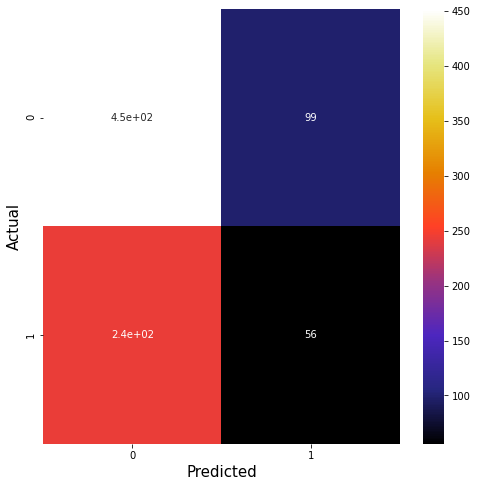

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(Y_test,y_pred),annot=True,cmap="CMRmap")
plt.xlabel("Predicted",fontdict={"fontsize":15})
plt.ylabel("Actual",fontdict={"fontsize":15})


In [ ]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.82      0.72       551
           1       0.36      0.19      0.25       300

    accuracy                           0.60       851
   macro avg       0.51      0.50      0.49       851
weighted avg       0.55      0.60      0.56       851



In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy : %1.1f"%(accuracy_score(Y_test,y_pred)*100))

accuracy : 59.7


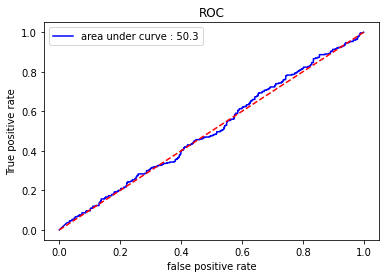

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
area_under_curve = roc_auc_score(Y_test,y_pred)
fpr,tpr,threshold = roc_curve(Y_test,best_model.predict_proba(X_test_)[:,1])
plt.plot(fpr,tpr,label="area under curve : %1.1f"%(area_under_curve*100),color="blue")
plt.plot([0,1],[0,1],"r--")
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("True positive rate")
plt.title("ROC")
plt.show()

In [ ]:
model_pipeline = Pipeline([
                           ("PCA",Pca_),
                           ("dd_model",best_model)
])

In [ ]:
filename = "dd_model_ml.pkl"
pickle.dump(model_pipeline,open(filename,"wb"))

In [ ]:
model_pipeline.predict(X_test[0].reshape(-1,1))

In [ ]:
!pip list

Package                       Version            
----------------------------- -------------------
absl-py                       0.12.0             
alabaster                     0.7.12             
albumentations                0.1.12             
altair                        4.1.0              
appdirs                       1.4.4              
argon2-cffi                   20.1.0             
arviz                         0.11.2             
astor                         0.8.1              
astropy                       4.2.1              
astunparse                    1.6.3              
async-generator               1.10               
atari-py                      0.2.9              
atomicwrites                  1.4.0              
attrs                         21.2.0             
audioread                     2.1.9              
autograd                      1.3                
Babel                         2.9.1              
backcall                      0.2.0              


In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
image_ = image.load_img("/content/drive/MyDrive/img205.png",target_size=(150,150))

In [ ]:
image_ = image.img_to_array(image_)
image_ = image_/255.0
image_

array([[[0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        ...,
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ]],

       [[0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        ...,
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ]],

       [[0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        ...,
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ]],

       ...,

       [[0.        , 0.98039216, 0.        ],
        [0.        , 0.98039216, 0.        ],
        [0.        , 0